## Reformatting NASA GEOS output files for analysis

In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
month = "06"
year = "2020"

In [3]:
filename = f"/Users/molina/GEOS_cape_hrly.UT.t{year+month}.r180W-30W_50S-50N.nc"

In [4]:
filename

'/Users/molina/GEOS_cape_hrly.UT.t202006.r180W-30W_50S-50N.nc'

In [5]:
ds = xr.open_dataset(filename, mask_and_scale=True)

In [6]:
ds

<xarray.Dataset>
Dimensions:    (Days: 30, Hours: 24, Latitudes: 200, Longitudes: 300)
Dimensions without coordinates: Days, Hours, Latitudes, Longitudes
Data variables:
    longitude  (Longitudes) float32 ...
    latitude   (Latitudes) float32 ...
    time       (Hours) float32 ...
    cape       (Days, Hours, Latitudes, Longitudes) float32 ...

In [7]:
datetime_range = pd.date_range(
    start=f"{year}-{month}-01", 
    freq="1H", 
    periods=len(ds.Days)*len(ds.Hours)
)

In [8]:
datetime_range = datetime_range + timedelta(hours=1) # add one hour bc of funky end of hour model timing

In [9]:
datetime_range

DatetimeIndex(['2020-06-01 01:00:00', '2020-06-01 02:00:00',
               '2020-06-01 03:00:00', '2020-06-01 04:00:00',
               '2020-06-01 05:00:00', '2020-06-01 06:00:00',
               '2020-06-01 07:00:00', '2020-06-01 08:00:00',
               '2020-06-01 09:00:00', '2020-06-01 10:00:00',
               ...
               '2020-06-30 15:00:00', '2020-06-30 16:00:00',
               '2020-06-30 17:00:00', '2020-06-30 18:00:00',
               '2020-06-30 19:00:00', '2020-06-30 20:00:00',
               '2020-06-30 21:00:00', '2020-06-30 22:00:00',
               '2020-06-30 23:00:00', '2020-07-01 00:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

In [10]:
newds = ds.where(
    ds['cape']!=1.e+15,np.nan).assign_coords(
    coords=dict(
        Longitudes=ds.longitude,
        Latitudes=ds.latitude,
        Datetime=datetime_range,
    )
).drop_vars(
    names=["longitude","latitude","time"]
).stack(Datetime=["Days","Hours"])["cape"].assign_attrs(
    missing_value=np.nan).to_dataset(
    name="cape").drop_vars("Datetime").assign_coords(
    coords=dict(
        Datetime=datetime_range,
    )
)

In [11]:
newds

<xarray.Dataset>
Dimensions:     (Datetime: 720, Latitudes: 200, Longitudes: 300)
Coordinates:
  * Longitudes  (Longitudes) float32 -179.75 -179.25 -178.75 ... -30.75 -30.25
  * Latitudes   (Latitudes) float32 -49.75 -49.25 -48.75 ... 48.75 49.25 49.75
  * Datetime    (Datetime) datetime64[ns] 2020-06-01T01:00:00 ... 2020-07-01
Data variables:
    cape        (Latitudes, Longitudes, Datetime) float32 15.78145 ... 22.125216

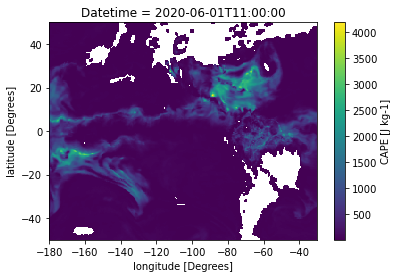

In [12]:
newds.isel(Datetime=10)["cape"].plot() # quick check

In [13]:
newds.to_netcdf(
    f"/Users/molina/GEOS_cape_hrly.UT.t{year+month}.r180W-30W_50S-50N_v2.nc"
)

### double-checking saved file

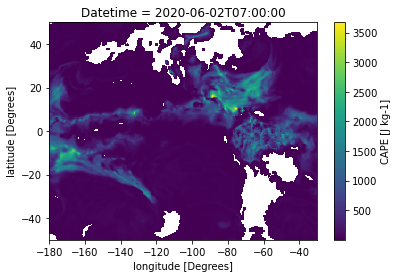

In [14]:
xr.open_dataset(
    f"/Users/molina/GEOS_cape_hrly.UT.t{year+month}.r180W-30W_50S-50N_v2.nc")["cape"].isel(Datetime=30).plot()